In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
sc.pp.neighbors(ec_top5, n_neighbors=15)
sc.tl.leiden(ec_top5, resolution=0.3, key_added="leiden")
sc.tl.umap(ec_top5)
sc.pl.umap(ec_top5, color=["leiden"])

### Full dataset for Protein Cluster Annotation

In [2]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2_final_4_species.h5mu'
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [3]:
data_nSBM["SC_proteins"].varm["protein_hierarchy"]

lev0           lev1           lev2  \
NP_052605.1      lev00totlen16795  forDFlev16795  forDFlev26795   
NP_052606.1      lev00totlen17549  forDFlev17549  forDFlev27549   
NP_052608.1      lev00totlen15594  forDFlev15594  forDFlev25594   
NP_052609.1      lev00totlen12063  forDFlev12063  forDFlev22063   
NP_052610.1       lev00totlen1576   forDFlev1576   forDFlev2576   
...                           ...            ...            ...   
WP_004152553.1   lev00totlen14198  forDFlev14198  forDFlev24198   
WP_004178188.1   lev00totlen11303  forDFlev11303  forDFlev21303   
WP_228131004.1   lev00totlen11253  forDFlev11253  forDFlev21253   
WP_228131000.1  lev020totlen21057  forDFlev11057  forDFlev21057   
WP_032417945.1   lev00totlen11212  forDFlev11212  forDFlev21212   

                         lev3           lev4           lev5           lev6  \
NP_052605.1     forDFlev36795  forDFlev46795  forDFlev56795  forDFlev66795   
NP_052606.1     forDFlev37549  forDFlev47549  forDFlev57549  forDFlev67549   
NP_052608.1     forDFlev35594  forDFlev45594  forDFlev55594  forDFlev65594   
NP_052609.1     forDFlev32063  forDFlev42063  forDFlev52063  forDFlev62063   
NP_052610.1      forDFlev3576   forDFlev4576   forDFlev5576   forDFlev6576   
...                       ...            ...            ...            ...   
WP_004152553.1  forDFlev34198  forDFlev44198  forDFlev54198  forDFlev64198   
WP_004178188.1  forDFlev31303  forDFlev41303  forDFlev51303  forDFlev61303   
WP_228131004.1  forDFlev31253  forDFlev41253  forDFlev51253  forDFlev61253   
WP_228131000.1  forDFlev31057  forDFlev41057  forDFlev51057  forDFlev61057   
WP_032417945.1  forDFlev31212  forDFlev41212  forDFlev51212  forDFlev61212   

               lev_root  
NP_052605.1        root  
NP_052606.1        root  
NP_052608.1        root  
NP_052609.1        root  
NP_052610.1        root  
...                 ...  
WP_004152553.1     root  
WP_004178188.1     root  
WP_228131004.1     root  
WP_228131000.1     root  
WP_032417945.1     root  

[13687 rows x 8 columns]

### EC

In [5]:
ec_mudata = md.read("../data/preprocessed_old/ec_mudata_preprocessed.h5mu")
ec_adata = ec_mudata["high_abundance_genes"].copy()
ec_adata = ec_adata[:, ec_adata.var["rRNA"]].copy()
sc.pp.filter_cells(ec_adata, min_counts=1)
del(ec_mudata)
print(gc.collect())
ec_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


2463


AnnData object with n_obs × n_vars = 2466 × 47
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [6]:
print("Sparsity:\t\t", calc_sparsity(ec_adata.X.A))
print("Mean counts per gene:\t", np.mean(np.sum(ec_adata.X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(ec_adata.X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(ec_adata.X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(ec_adata.X.A, axis=0)))

Sparsity:		 0.9074908112025677
Mean counts per gene:	 5.223844
Median counts per gene:	 4.0
Mean genes per cell: 	 274.0851
Median genes per cell:	 234.0


### Aggregate to PCs
Not needed here because every gene is in a different PC

In [7]:
ec_adata.var['PC'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_adata.var["protein"]]["lev6"].values
ec_adata.var.PC.value_counts().unique()

array([1], dtype=int64)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


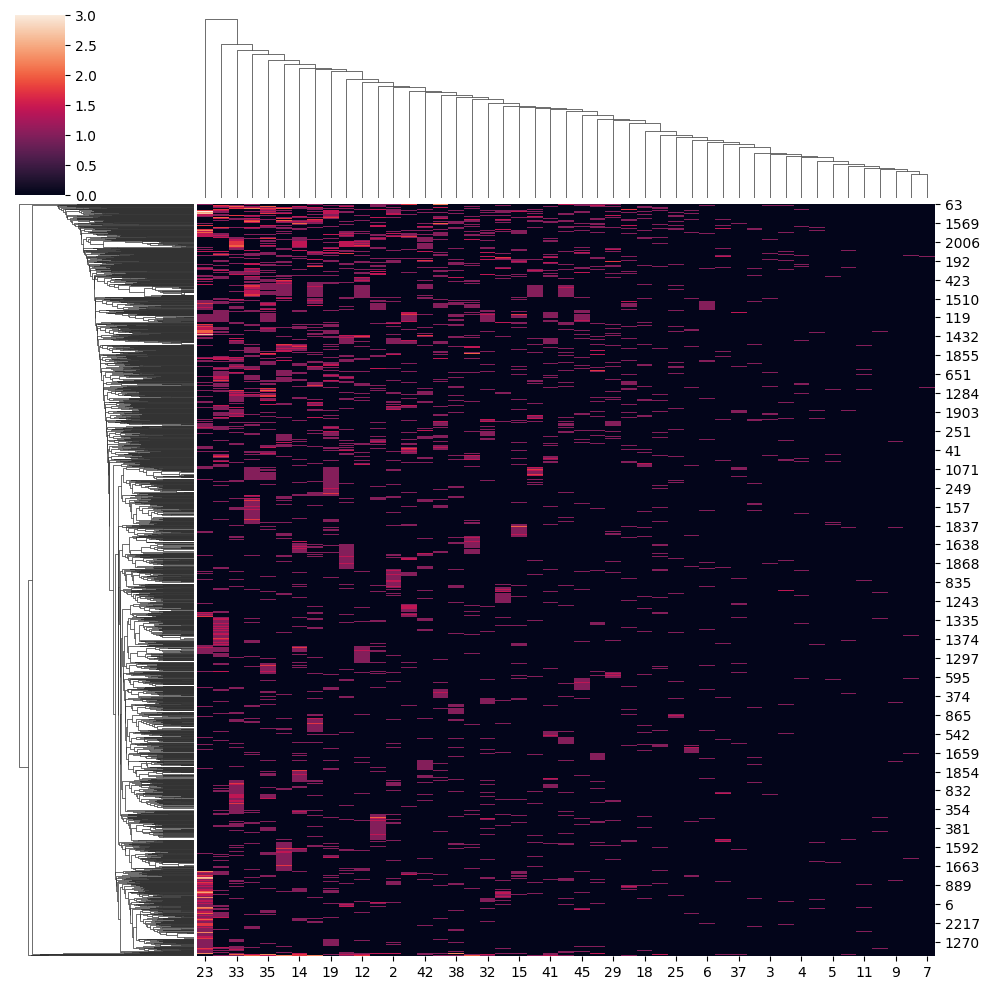

In [8]:
sns.clustermap(ec_adata.layers['sqrt_counts'].A)

### Estimating latent correlation with latentcor

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


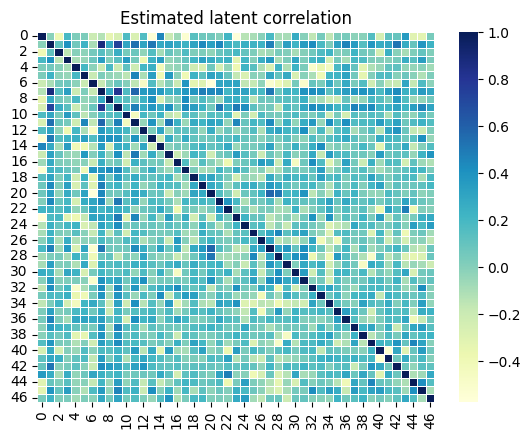

In [9]:
tps = ['tru' for i in range(ec_adata.shape[1])]
ec_est = latentcor(ec_adata.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

### Single Graphical Lasso with GGL
Modelselection for lambda based on eBIC

In [10]:
ec_ggl_latentcor = gg_lasso_network_analysis(N=ec_adata.shape[0], estimate=ec_est)
ec_ggl_latentcor.create_problem(S_col="R", latent=False)
ec_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 11 iterations wi

In [11]:
ec_sol_latentcor = ec_ggl_latentcor.P.solution.precision_ * -1

<Axes: >

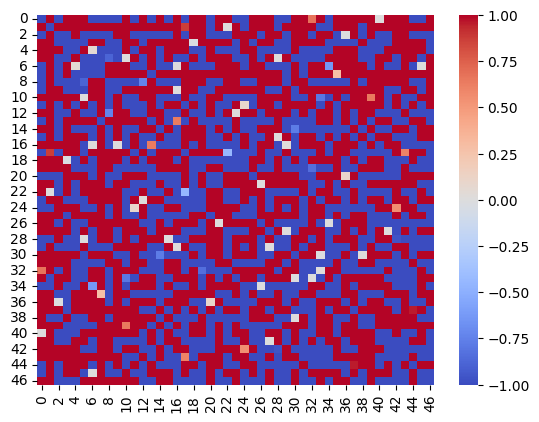

In [ ]:
sns.heatmap(ec_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

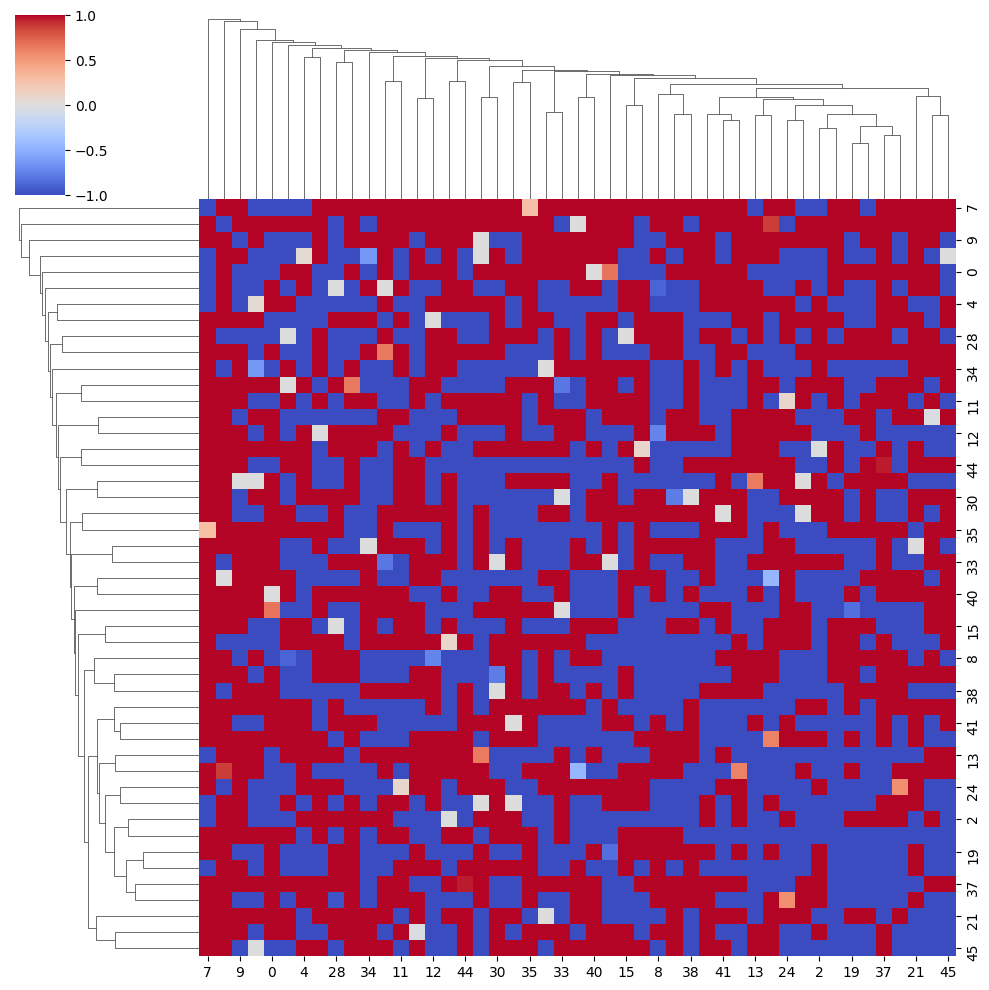

In [21]:
sns.clustermap(ec_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

### EFM

In [22]:
efm_mudata = md.read("../data/preprocessed/efm_mudata_preprocessed.h5mu")
efm_adata = efm_mudata["high_abundance_genes"].copy()
efm_adata = efm_adata[:, efm_adata.var["rRNA"]].copy()
sc.pp.filter_cells(efm_adata, min_counts=1)
del(efm_mudata)
print(gc.collect())
efm_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot j

2285


AnnData object with n_obs × n_vars = 4563 × 52
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [23]:
print("Sparity:\t\t", calc_sparsity(efm_adata.X.A))
print("Mean counts per gene:\t", np.mean(np.sum(efm_adata.X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(efm_adata.X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(efm_adata.X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(efm_adata.X.A, axis=0)))

Sparity:		 0.9215597026247914
Mean counts per gene:	 4.0788956
Median counts per gene:	 3.0
Mean genes per cell: 	 357.92307
Median genes per cell:	 272.5


### Aggregate to PCs
Not needed here because every gene is in a different PC

In [24]:
efm_adata.var['PC'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_adata.var["protein"]]["lev6"].values
efm_adata.var.PC.value_counts().unique()

array([1], dtype=int64)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


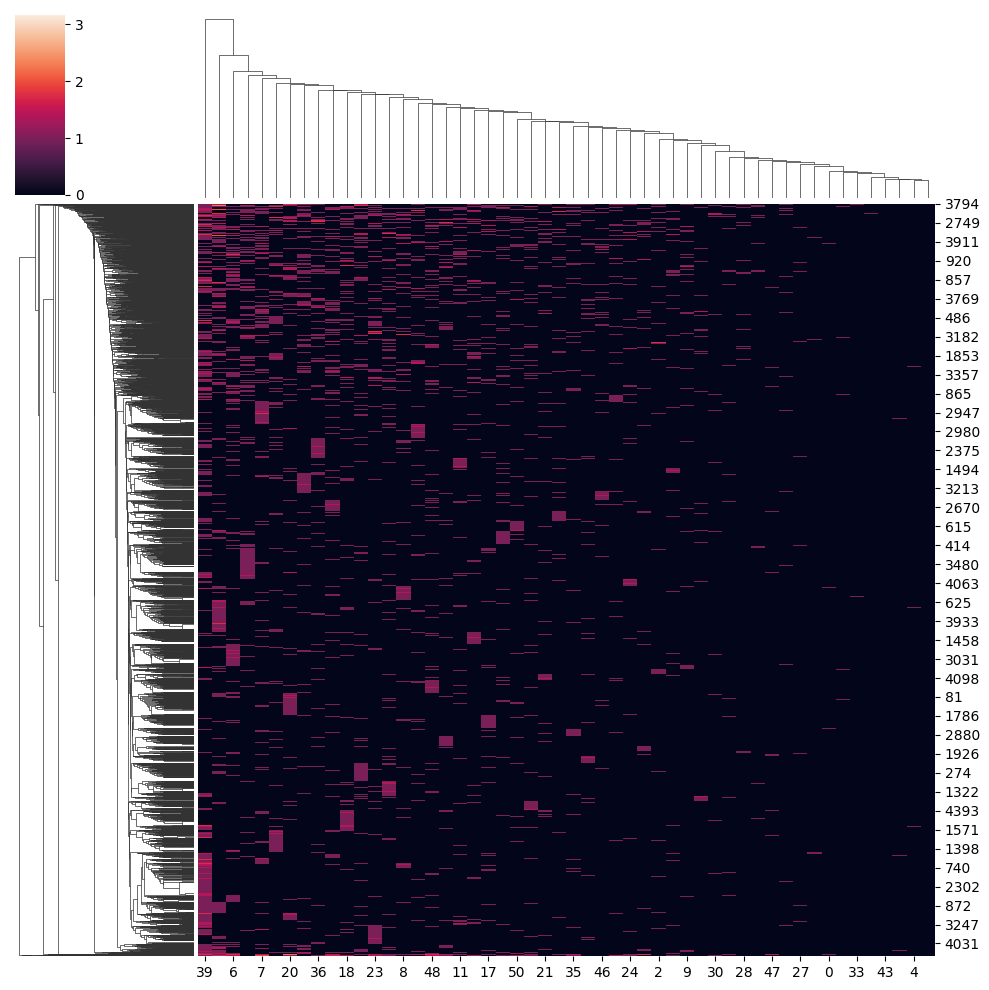

In [25]:
sns.clustermap(efm_adata.layers['sqrt_counts'].A)

### Estimating latent correlation with latentcor

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


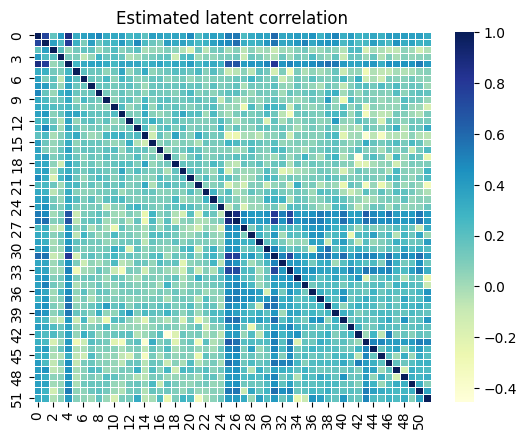

In [26]:
tps = ['tru' for i in range(efm_adata.shape[1])]
efm_est = latentcor(efm_adata.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

### Single Graphical Lasso with GGL
Modelselection for lambda based on eBIC

In [27]:
efm_ggl_latentcor = gg_lasso_network_analysis(N=efm_adata.shape[0], estimate=efm_est)
efm_ggl_latentcor.create_problem(S_col="R", latent=False)
efm_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 39 iterations with status: optimal.
ADMM terminated after 42 iterations wi

In [28]:
efm_sol_latentcor = efm_ggl_latentcor.P.solution.precision_ *-1

<Axes: >

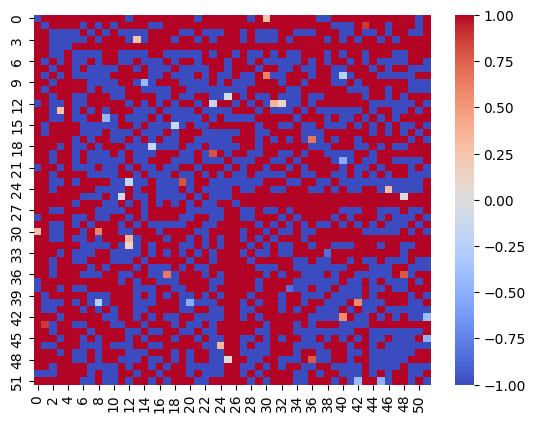

In [29]:
sns.heatmap(efm_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

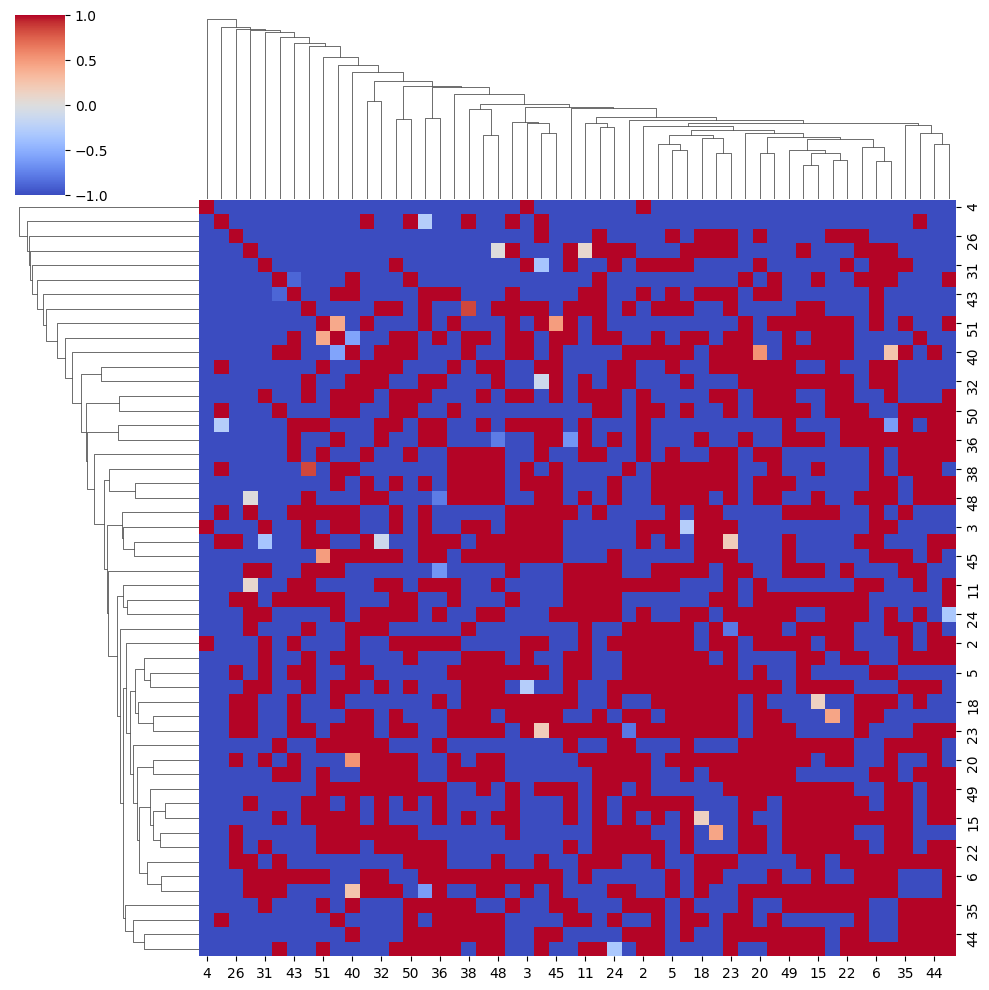

In [30]:
sns.clustermap(efm_sol_latentcor*-1, cmap="coolwarm", vmin=-1, vmax=1)

### Plotting the resulting Networks

In [75]:
def extract_part(text):
    parts = text.split()
    return parts[1] + '-' + parts[5]  # Remove the last part

In [91]:
ec_adata.var["short_protein_name"] = ec_adata.var["protein_name"].apply(lambda x: extract_part(x))
ec_adata.var["short_protein_name"] = ec_adata.var["short_protein_name"].astype(str)
ec_adata.var.loc[ec_adata.var.index[1], "short_protein_name"] = 'S12 methylthiotransferase'

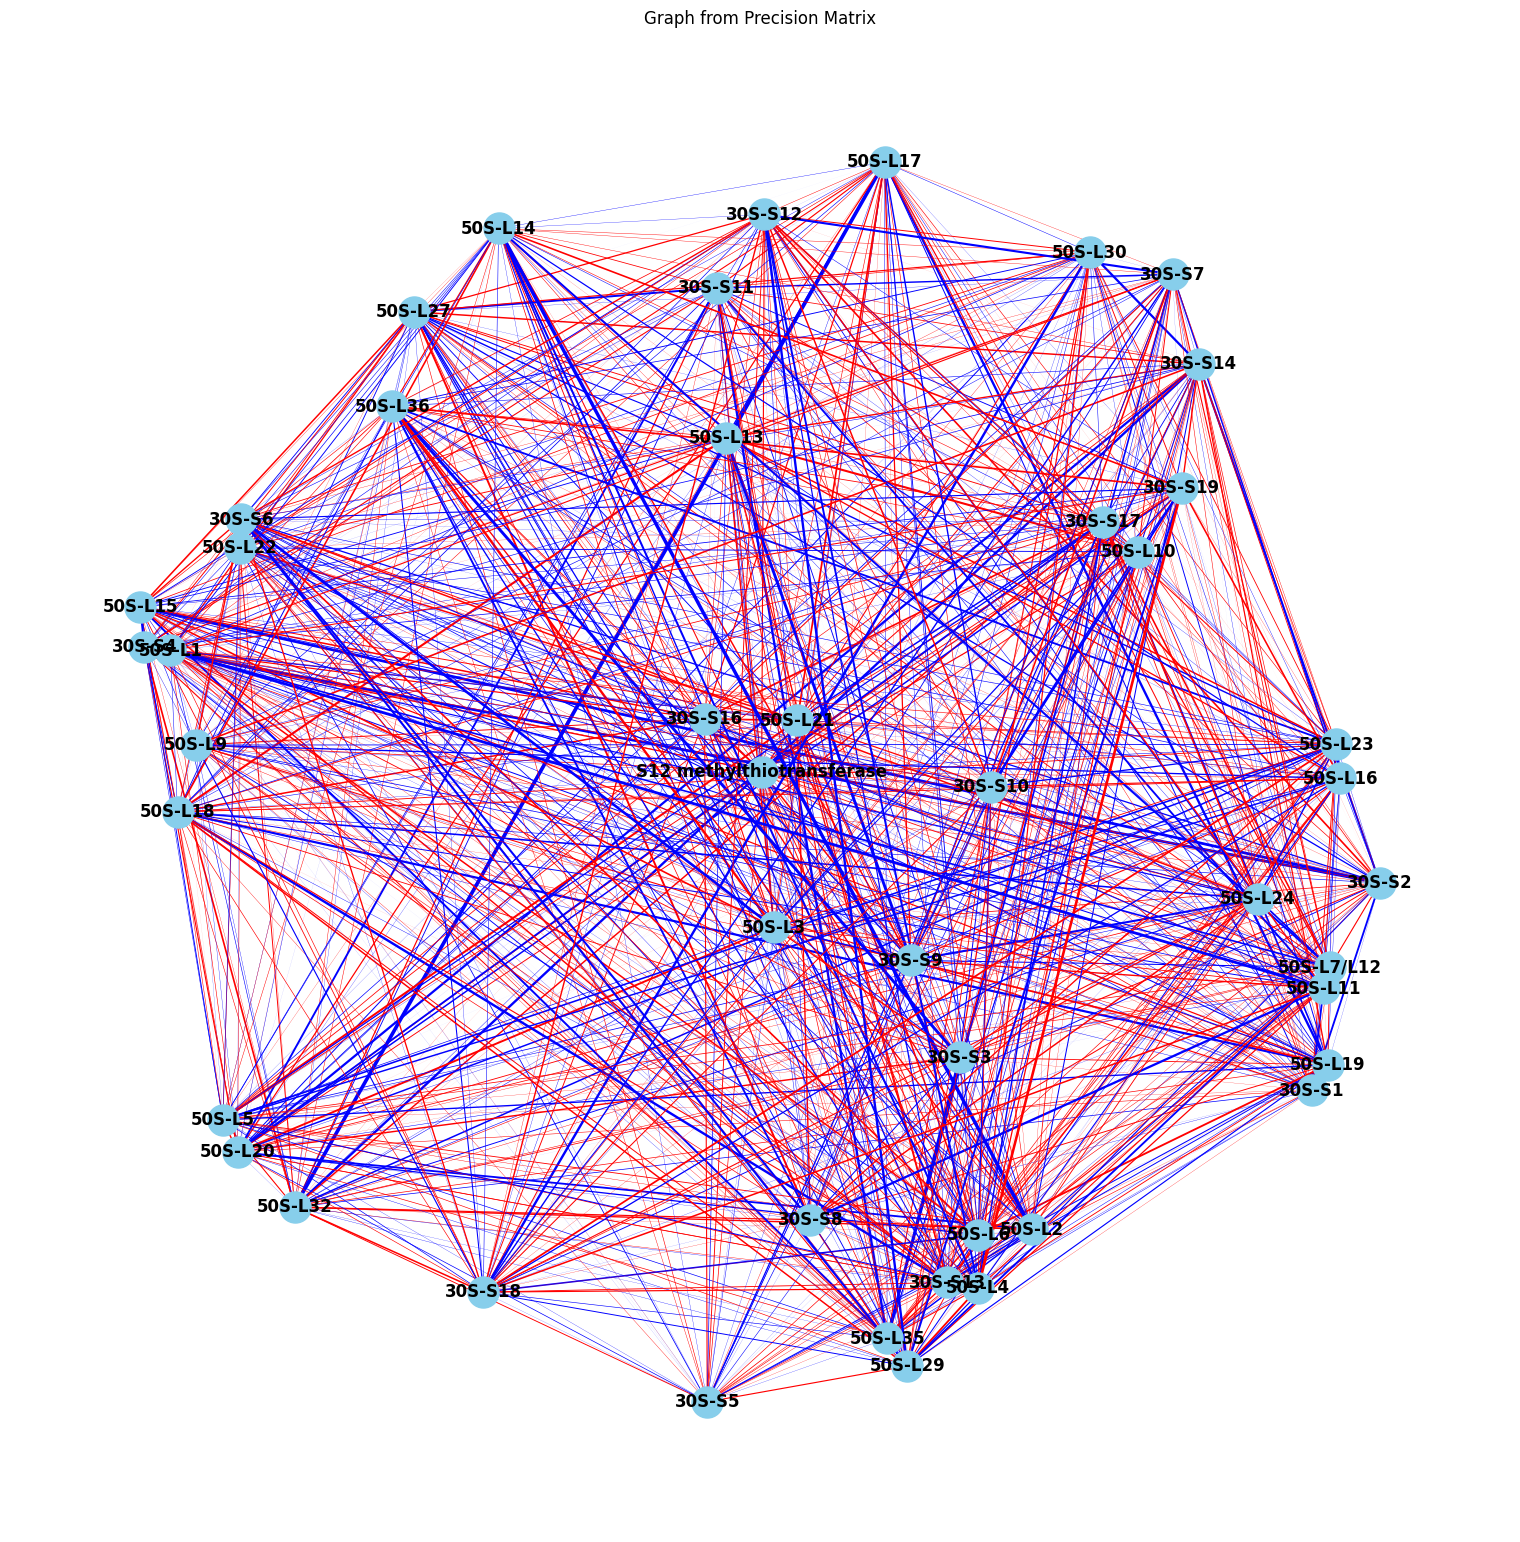

In [96]:
ec_G = nx.Graph()

# Add nodes to the graph
for idx, row in ec_adata.var.iterrows():
    ec_G.add_node(row['short_protein_name'])

# Add edges to the graph based on the weights
n = len(ec_adata.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = ec_sol_latentcor[i, j]
        if weight != 0:
            ec_G.add_edge(ec_adata.var.iloc[i]['short_protein_name'], ec_adata.var.iloc[j]['short_protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight


# Draw the graph
pos = nx.spring_layout(ec_G)
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

In [104]:
def extract_part(text):
    parts = text.split()
    return parts[2] + "-" + parts[5]  # Remove the last part

In [118]:
efm_adata.var["short_protein_name"] = efm_adata.var["protein_name"].apply(lambda x: extract_part(x))
efm_adata.var["short_protein_name"] = efm_adata.var["short_protein_name"].astype(str)
efm_adata.var.loc["cds-WP_138820979.1", "short_protein_name"] = "30S-S6"
efm_adata.var.loc["cds-WP_002288673.1", "short_protein_name"] = "30S-S14"
efm_adata.var.loc["cds-WP_002290330.1", "short_protein_name"] = "50S-L31"

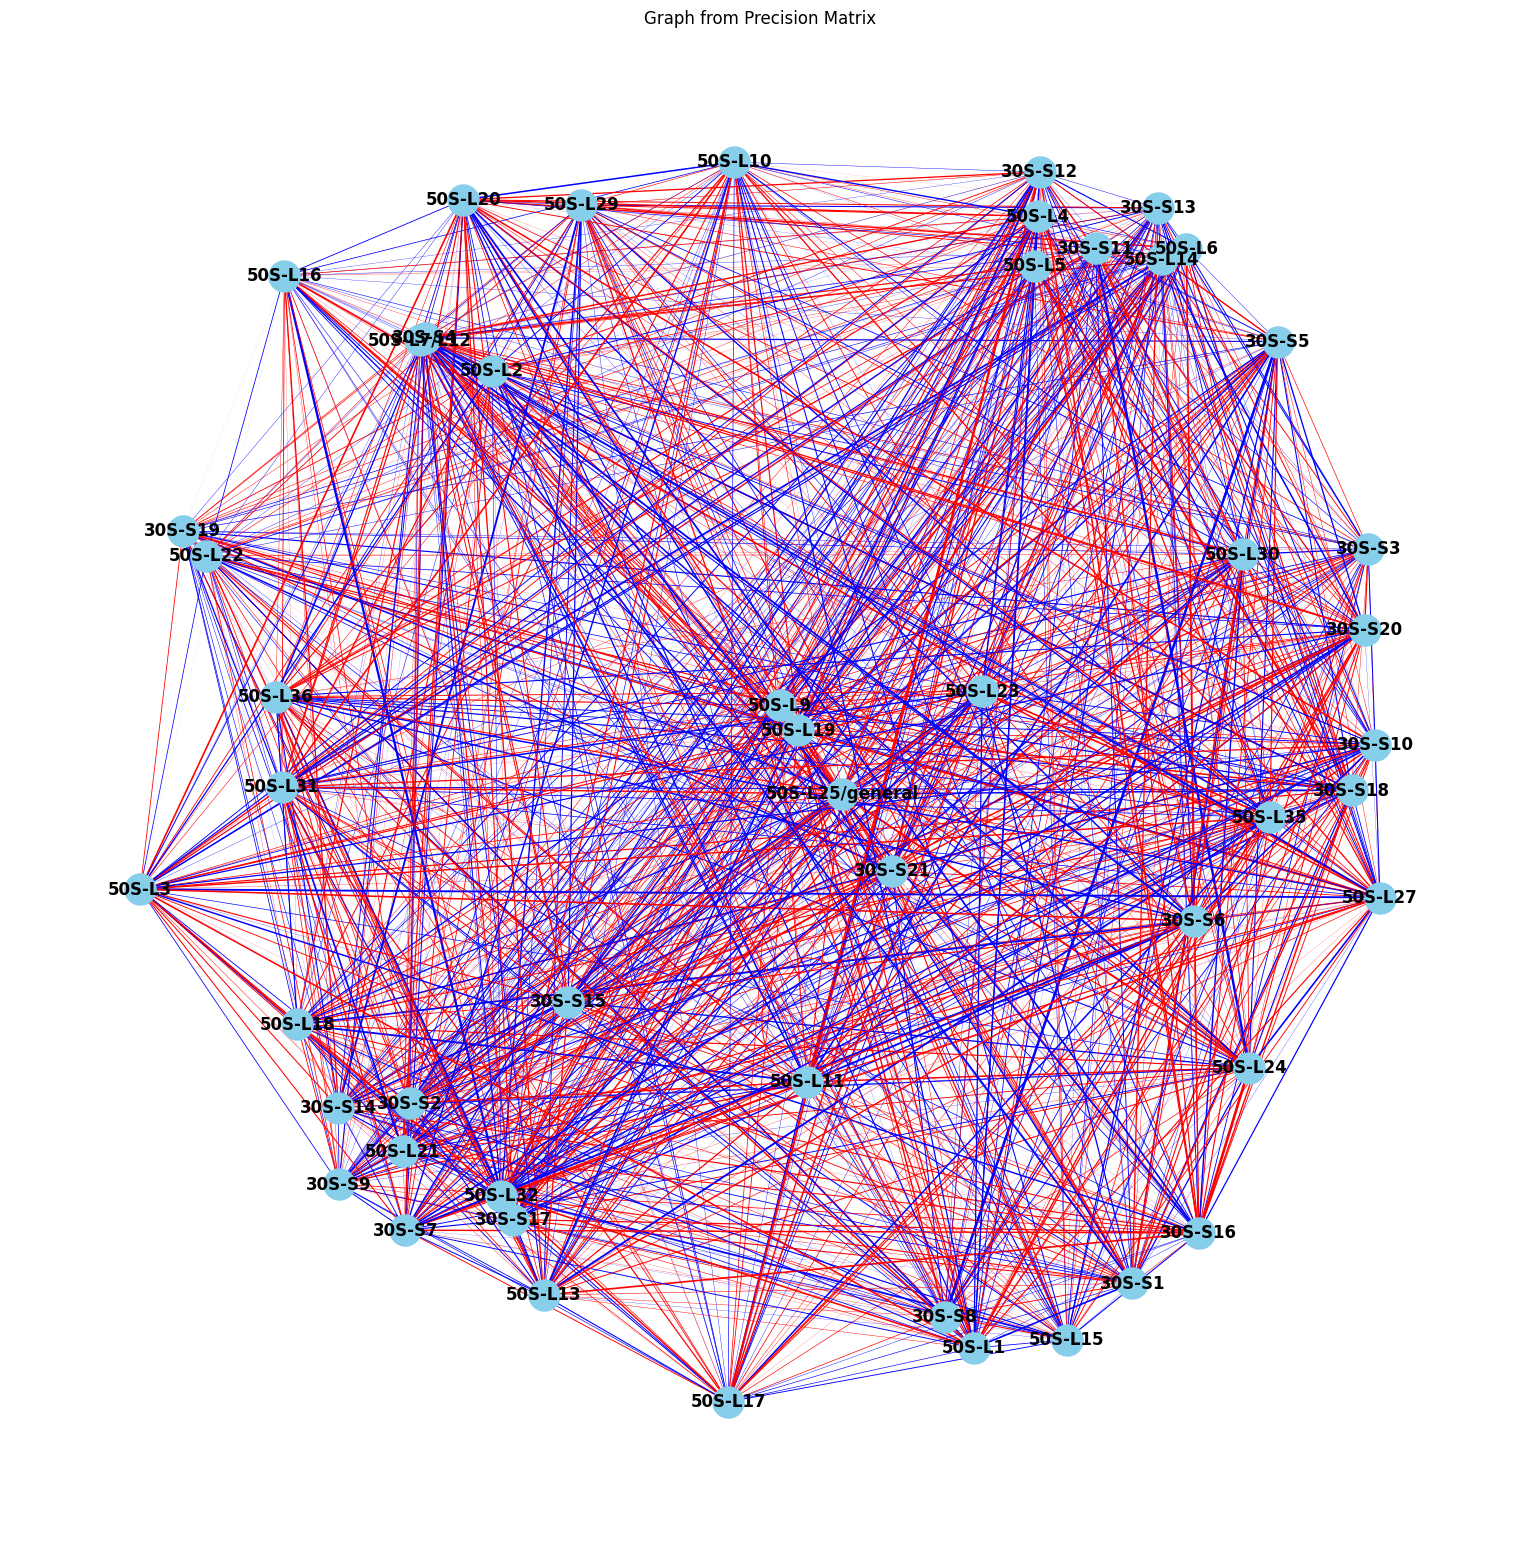

In [148]:
efm_G = nx.Graph()

# Add nodes to the graph
for idx, row in efm_adata.var.iterrows():
    efm_G.add_node(row['short_protein_name'])

# Add edges to the graph based on the weights
n = len(efm_adata.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = efm_sol_latentcor[i, j]
        if weight != 0:
            efm_G.add_edge(efm_adata.var.iloc[i]['short_protein_name'], efm_adata.var.iloc[j]['short_protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in efm_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    #edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight
    edge_widths.append(np.log10(abs(weight) * 0.1))
# Draw the graph
pos = nx.spring_layout(efm_G)
plt.figure(figsize=(15, 15))
nx.draw(efm_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

### Getting the top 5 correlations for both species

<Axes: >

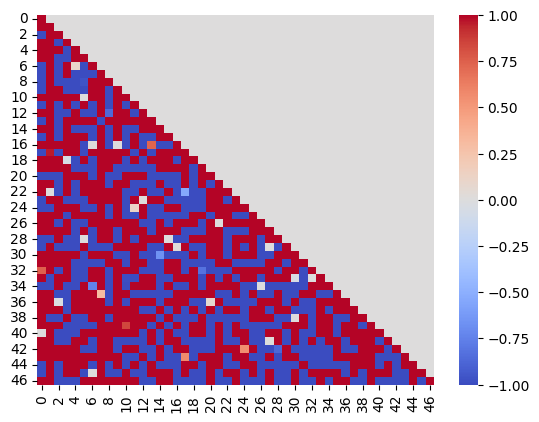

In [48]:
ec_sol_latentcor[np.triu_indices(ec_sol_latentcor.shape[0])] = 0
np.fill_diagonal(ec_sol_latentcor, 1)
sns.heatmap(ec_sol_latentcor, vmin=-1, vmax=1, cmap="coolwarm")

In [49]:
flat_dummy = ec_sol_latentcor.flatten()
ec_top5_corr = np.argsort(flat_dummy)[::-1][:5]

In [50]:
ec_top5_row_indices, ec_top5_col_indices = np.unravel_index(ec_top5_corr, ec_sol_latentcor.shape)

In [51]:
for i in range(5):
    print(f"Top {i+1} entry:")
    print(ec_adata.var.iloc[ec_top5_row_indices[i]][["protein", "protein_name", "PC"]])
    print(ec_adata.var.iloc[ec_top5_col_indices[i]][["protein", "protein_name", "PC"]])
    print("____________________")

Top 1 entry:
protein                              NP_312211.1
protein_name    50S ribosomal subunit protein L4
PC                                 forDFlev63034
Name: cds-NP_312211.1, dtype: object
protein                               NP_312208.1
protein_name    30S ribosomal subunit protein S19
PC                                  forDFlev63141
Name: cds-NP_312208.1, dtype: object
____________________
Top 2 entry:
protein                              NP_312212.1
protein_name    50S ribosomal subunit protein L3
PC                                  forDFlev6724
Name: cds-NP_312212.1, dtype: object
protein                               NP_312191.1
protein_name    50S ribosomal subunit protein L36
PC                                  forDFlev65070
Name: cds-NP_312191.1, dtype: object
____________________
Top 3 entry:
protein                               NP_312935.1
protein_name    50S ribosomal subunit protein L10
PC                                  forDFlev61182
Name: cds-NP_312935.1, dtyp

In [92]:
ec_sol_latentcor[35]

array([ -4.919858  , -14.34383569,   4.31911397,   3.40784298,
       -11.41588984, -11.38926665, -10.17549075,  -0.        ,
        11.62354933,  -0.        ,  -1.01752286,   2.84683721,
        -0.        ,   3.15056025,   0.        ,  10.44495945,
        -3.03221696,  -3.21742513, -10.4082682 ,  -5.00856495,
       -14.0175118 ,   5.17465721,   1.74727644,  -1.39140981,
        12.26872324,  -0.57738008,  24.87335332,  17.40989512,
       -17.64923601,  11.29916439,   6.78626905,  -8.89131223,
       -30.87358068,  -0.        ,  -0.        ,  52.09214324,
        -1.807367  ,  -8.38129002,   2.93749641,  22.00795608,
         0.        ,   0.        , -11.91690422,  -7.55010732,
        -0.        ,  -9.14152051,  -5.92598324])

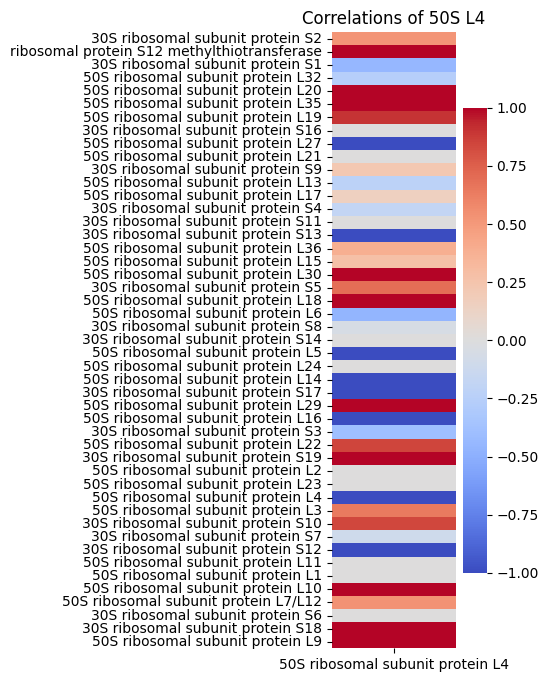

In [99]:
plt.figure(figsize=(2, 8))
ax = sns.heatmap(pd.DataFrame(ec_sol_latentcor[35]*-1), 
                 cmap="coolwarm", vmin=-1, vmax=1,
                 yticklabels=ec_adata.var["protein_name"],
                 xticklabels=[ec_adata.var.iloc[35]["protein_name"]])
plt.title('Correlations of 50S L4')
plt.show()

In [57]:
ec_adata.var.iloc[35]

strains                                 GSM5456506_Kp_CDS
matchin_protein                                     match
protein                                       NP_312211.1
n_cells                                               872
protein_name             50S ribosomal subunit protein L4
rRNA                                                 True
n_cells_by_counts                                     535
mean_counts                                      0.254754
pct_dropout_by_counts                           78.803487
total_counts                                        643.0
n_counts                                            643.0
PC                                          forDFlev63034
Name: cds-NP_312211.1, dtype: object

<Axes: >

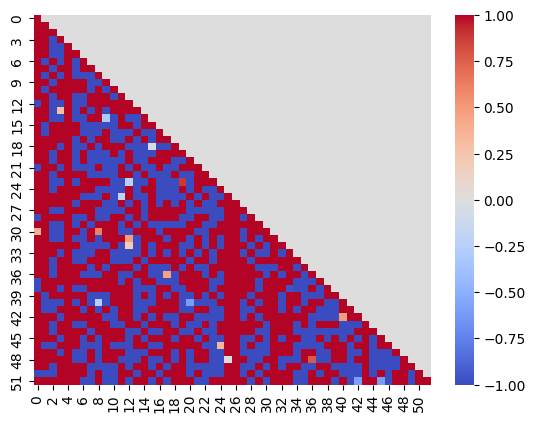

In [52]:
efm_sol_latentcor = efm_sol_latentcor*-1
efm_sol_latentcor[np.triu_indices(efm_sol_latentcor.shape[0])] = 0
np.fill_diagonal(efm_sol_latentcor, 1)
sns.heatmap(efm_sol_latentcor, vmin=-1, vmax=1, cmap="coolwarm")

In [53]:
flat_dummy = efm_sol_latentcor.flatten()
efm_top5_corr = np.argsort(flat_dummy)[::-1][:5]

In [54]:
efm_top5_row_indices, efm_top5_col_indices = np.unravel_index(efm_top5_corr, efm_sol_latentcor.shape)

In [55]:
for i in range(5):
    print(f"Top {i+1} entry:")
    print(efm_adata.var.iloc[efm_top5_row_indices[i]][["protein", "protein_name", "PC"]])
    print(efm_adata.var.iloc[efm_top5_col_indices[i]][["protein", "protein_name", "PC"]])
    print("____________________")

Top 1 entry:
protein                   WP_002287505.1
protein_name    30S ribosomal protein S9
PC                         forDFlev64834
Name: cds-WP_002287505.1, dtype: object
protein                    WP_002287321.1
protein_name    30S ribosomal protein S21
PC                           forDFlev6102
Name: cds-WP_002287321.1, dtype: object
____________________
Top 2 entry:
protein                    WP_002290449.1
protein_name    50S ribosomal protein L23
PC                          forDFlev67218
Name: cds-WP_002290449.1, dtype: object
protein                    WP_002289309.1
protein_name    50S ribosomal protein L35
PC                          forDFlev62492
Name: cds-WP_002289309.1, dtype: object
____________________
Top 3 entry:
protein                    WP_002295975.1
protein_name    50S ribosomal protein L13
PC                          forDFlev64086
Name: cds-WP_002295975.1, dtype: object
protein                    WP_002290274.1
protein_name    30S ribosomal protein S16
PC      